## PEAK 3 Y24 phosphorylation

model PEAK3

J0: PEAK3_Y24 -> PEAK3_Y24P; J0_Vmax*PEAK3_Y24/(J0_Km + PEAK3_Y24)
J1: PEAK3_Y24P -> PEAK3_Y24; J1_Vmax*PEAK3_Y24P/(J1_Km + PEAK3_Y24P)

# State variables in the system
PEAK3_Y24=100
PEAK3_Y24P=0

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end


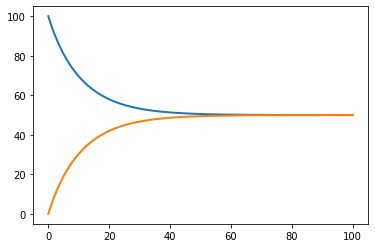

In [4]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('PEAK3_Y24',), ('PEAK3_Y24P',)))
model.add_reaction(Reaction(michaelis_menten, ('PEAK3_Y24P',), ('PEAK3_Y24',), reactant_values=0, product_values=100))

print(model.get_antimony_model())

model.simulate(0, 100, 100)
model.plot()


In [ ]:
# use antimony's default modularity to create model 

import antimony
import roadrunner
import matplotlib.pyplot as plt

ant_model = """

model MichaelisMenten(F, B)
    J0:F -> B; Vmf * F / (Kmf + F)
    J1:B -> F; Vmb * B / (Kmb + B)

    # default values
    Vmf = 10
    Vmb = 10
    Kmf = 100
    Kmb = 100
end

model SimpleMassAction(A, B)
    J0:A -> B; ka * A - kd * B
    J1:B -> A; kd * B - ka * A
    # default values
    ka = 0.01
    kd = 0.01
end

model MassAction21(A,B,AB)
    J0:A + B -> AB; ka * A * B - kd * AB
    J1:AB -> A + B; kd * AB - ka * A * B

    # default values
    ka = 0.001
    kd = 0.01

    # bound variables
    TA = A + AB
    TB = B + AB

end


model simple_peak3
    # Examples of different rate laws and initialization
    
    E0: MassAction21(PEAK3, GRB2, PEAK3_GRB2)
    E1: MassAction21(PEAK3, CRKII, PEAK3_CRKII)
    E2: MassAction21(TotalGRB2, ASAP1, GRB2_ASAP1)
    E3: MassAction21(TotalCRKII, ASAP1, CRKII_ASAP1)

    PEAK3 = 100 
    GRB2 = 100
    CRKII = 100
    TotalGRB2 = GRB2 + PEAK3_GRB2 
    TotalCRKII = CRKII + PEAK3_CRKII
    ASAP1 = 100

end
"""

antimony.clearPreviousLoads()
antimony.freeAll()
code = antimony.loadAntimonyString(ant_model)
if code >= 0:
    mid = antimony.getMainModuleName()
    sbml_model = antimony.getSBMLString(mid)
    print('Antimony model compiled without error')
else:
    print(code)
r_model = roadrunner.RoadRunner(sbml_model)
# r_model.model['S3'] = 1
# print(r_model.model['S3'])


r_solved = r_model.simulate(0, 100, 100)

print(r_solved)

r_model.plot()

# plt.plot(r_solved['time'], label='TA')
# plt.legend()
# plt.grid()
# plt.show()

print(r_model.model.keys())
# print(r_model.model['S3'])
# print(r_solved)
# plt.plot(r_solved)


## Testing ground

In [26]:
import itertools

l = ['A', 'B', 'C', 'D']
r = list(itertools.combinations(l, 3))

# A bind both B and C
# D bind to either B or C

print(r)

[('A', 'B', 'C'), ('A', 'B', 'D'), ('A', 'C', 'D'), ('B', 'C', 'D')]


In [ ]:
## Representing Protein A with 1 binding site 
# A_0 + B -> A_1B

## Building PEAK3 model using ModelBuilder

model peak3model

cr1: pEGFR -> EGFR; cr1_Vmax*pEGFR/(cr1_Km + pEGFR)
cr2: EGFR -> pEGFR; cr2_Vmax*EGFR*egf/(cr2_Km + EGFR)
J2: rpEGFR -> rEGFR; cr1_Vmax*rpEGFR/(cr1_Km + rpEGFR)
J3: rEGFR -> rpEGFR; cr2_Vmax*rEGFR*egf/(cr2_Km + rEGFR)
cr3: rEGFR -> EGFR; cr3_Vmax*rEGFR/(cr3_Km + rEGFR)
cr4: EGFR -> rEGFR; cr4_Vmax*EGFR*total_PEAK3/(cr4_Km + EGFR)
J6: rpEGFR -> pEGFR; cr3_Vmax*rpEGFR/(cr3_Km + rpEGFR)
J7: pEGFR -> rpEGFR; cr4_Vmax*pEGFR*total_PEAK3/(cr4_Km + pEGFR)
core1: pPEAK3 -> PEAK3; core1_Vmax*pPEAK3*rpShc/(core1_Km + pPEAK3)
core1b: PEAK3 -> pPEAK3; core1b_Vmax*PEAK3/(core1b_Km + PEAK3)
cr5: pShc -> Shc; cr5_Vmax*pShc/(cr5_Km + pShc)
cr6: Shc -> pShc; cr6_Vmax*Shc*total_pEGFR/(cr6_Km + Shc)
J12: rpShc -> rShc; cr5_Vmax*rpShc/(cr5_Km + rpShc)
J13: rShc -> rpShc; cr6_Vmax*rShc*total_pEGFR/(cr6_Km + rShc)
cr7: rShc -> Shc; cr7_Vmax*rShc/(cr7_Km + rShc)
cr8: Shc -> rShc; cr8_Vmax*Shc*total_PEAK3/(cr8_Km + Shc)
J16: rpShc -> pShc; cr7_Vmax*rpShc/(cr7_Km + rpShc)
J17: pShc -> rpShc; c

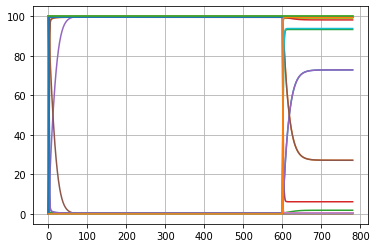

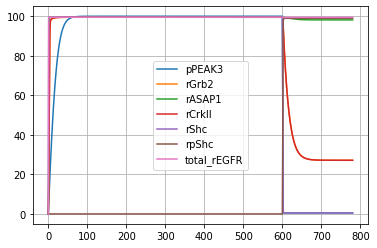

In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import roadrunner
import matplotlib.pyplot as plt

peak3_model = ModelBuilder('peak3model')

# naming key:
# p = phosphorylated
# r = recruited

## Upstream EGF signalling 

# Input: EGF, PEAK3_total
# Output: pEGFR, rEGFR (in total)

# EGFR <-> pEGFR
peak3_model.add_reaction(Reaction(michaelis_menten, ('pEGFR',), ('EGFR',), 'cr1', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('EGFR',), ('pEGFR',), 'cr2', extra_states=('egf',), zero_init=True))

# rEGFR <-> rpEGFR
peak3_model.add_reaction(Reaction(michaelis_menten, ('rpEGFR',), ('rEGFR',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr1', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('rEGFR',), ('rpEGFR',), extra_states=('egf',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr2', zero_init=True))

# EGFR <-> rEGFR 
peak3_model.add_reaction(Reaction(michaelis_menten, ('rEGFR',), ('EGFR',), 'cr3', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('EGFR',), ('rEGFR',), 'cr4', extra_states=('total_PEAK3',), zero_init=True))

# pEGFR <-> rpEGFR
peak3_model.add_reaction(Reaction(michaelis_menten, ('rpEGFR',), ('pEGFR',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr3', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('pEGFR',), ('rpEGFR',), extra_states=('total_PEAK3',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr4', zero_init=True))


## PEAK3 

# Input: rpShc, Grb2
# Output: pPEAK3, total PEAK3

# PEAK3 <-> pPEAK3
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('pPEAK3',), ('PEAK3',), 'core1', extra_states=('rpShc',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten, ('PEAK3',), ('pPEAK3',), 'core1b',zero_init=True))

## Shc complex formation and dephosphorylation of PEAK3 

# Input: total_pEGFR, pPEAK3
# Output to PEAK3: rpShc 

peak3_model.add_reaction(Reaction(michaelis_menten, ('pShc',), ('Shc',), 'cr5', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('Shc',), ('pShc',), 'cr6', extra_states=('total_pEGFR',), zero_init=True))

peak3_model.add_reaction(Reaction(michaelis_menten, ('rpShc',), ('rShc',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr5', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('rShc',), ('rpShc',), extra_states=('total_pEGFR',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr6', zero_init=True))

peak3_model.add_reaction(Reaction(michaelis_menten, ('rShc',), ('Shc',), 'cr7', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('Shc',), ('rShc',), 'cr8',extra_states=('total_PEAK3',), zero_init=True))

peak3_model.add_reaction(Reaction(michaelis_menten, ('rpShc',), ('pShc',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr7', zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('pShc',), ('rpShc',), extra_states=('total_PEAK3',), reactant_values=0, product_values=0, use_parameter_from_reaction='cr8', zero_init=True))


## PEAK3 downstream signalling

peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('Grb2',), ('rGrb2',), 'cr9', extra_states=('pPEAK3',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten, ('rGrb2',), ('Grb2',), 'cr10', zero_init=True))

peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('ASAP1',), ('rASAP1',), 'cr11', extra_states=('rGrb2',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten, ('rASAP1',), ('ASAP1',), 'cr12', zero_init=True))

peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('CrkII',), ('rCrkII',), 'cr13', extra_states=('pPEAK3',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten, ('rCrkII',), ('CrkII',), 'cr14', zero_init=True))


## SFK activation and phosphorylation of PEAK3

peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('SFK',), ('aSFK',), 'cr15', extra_states=('total_pEGFR',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten, ('aSFK',), ('SFK',), 'cr16', zero_init=True))


peak3_model.add_simple_piecewise(0,600.1,8.33,'egf')
peak3_model.add_custom_variables('total_PEAK3', 'total_PEAK3 := pPEAK3 + PEAK3')
peak3_model.add_custom_variables('total_pEGFR', 'total_pEGFR := pEGFR + rpEGFR')
peak3_model.add_custom_variables('total_rEGFR', 'total_rEGFR := rEGFR + rpEGFR')
peak3_model.add_custom_variables('total_pShc', 'total_pShc := rpShc + pShc')
peak3_model.add_custom_variables('total_Grb2', 'total_Grb2 := rGrb2 + Grb2')


init_species = ['EGFR','PEAK3', 'Shc', 'Grb2', 'ASAP1', 'CrkII', 'SFK']

for s in init_species:
    peak3_model.add_enforce_state_value(s, 100)

print(peak3_model.get_antimony_model())

### FINISHED MODEL CONSTRUCTION, BEGIN TEST SIMULATION

sbml = peak3_model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = peak3_model.get_all_variables_keys()
custom_states = peak3_model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 780, 780, selections=sim_states)

states_no_egf = [s for s in states if s != 'egf']
observable_states = ['pPEAK3', 'rGrb2', 'rASAP1', 'rCrkII', 'rShc', 'rpShc', 'total_rEGFR']

peak3_model.save_model_as_pickle('models\\peak3\\peak3_model.pkl')

for state in states_no_egf:
    plt.plot(res['time'], res[f'{state}'], label=state)

# plt.legend()
plt.grid()
plt.show()

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()



Model Name peak3model
Number of Reactions 26
Number of State Variables 18
Number of Parameters 36
Number of Custom Variables 6
Number of Enforced State Values 7
Number of Custom Strings 0

model newpeak3model

cr1: pEGFR -> EGFR; cr1_Vmax*pEGFR/(cr1_Km + pEGFR)
cr2: EGFR -> pEGFR; cr2_Vmax*EGFR*egf/(cr2_Km + EGFR)
J2: rpEGFR -> rEGFR; cr1_Vmax*rpEGFR/(cr1_Km + rpEGFR)
J3: rEGFR -> rpEGFR; cr2_Vmax*rEGFR*egf/(cr2_Km + rEGFR)
cr3: rEGFR -> EGFR; cr3_Vmax*rEGFR/(cr3_Km + rEGFR)
cr4: EGFR -> rEGFR; cr4_Vmax*EGFR*total_PEAK3/(cr4_Km + EGFR)
J6: rpEGFR -> pEGFR; cr3_Vmax*rpEGFR/(cr3_Km + rpEGFR)
J7: pEGFR -> rpEGFR; cr4_Vmax*pEGFR*total_PEAK3/(cr4_Km + pEGFR)
core1: pPEAK3 -> PEAK3; core1_Vmax*pPEAK3*rpShc/(core1_Km + pPEAK3)
core1b: PEAK3 -> pPEAK3; core1b_Vmax*PEAK3/(core1b_Km + PEAK3)
cr5: pShc -> Shc; cr5_Vmax*pShc/(cr5_Km + pShc)
cr6: Shc -> pShc; cr6_Vmax*Shc*total_pEGFR/(cr6_Km + Shc)
J12: rpShc -> rShc; cr5_Vmax*rpShc/(cr5_Km + rpShc)
J13: rShc -> rpShc; cr6_Vmax*rShc*total_pEGFR/(cr

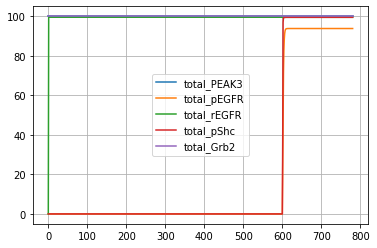

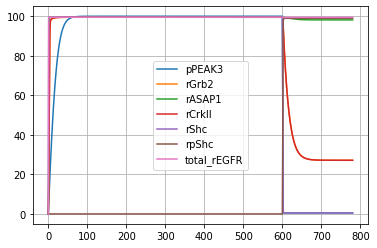

In [4]:
import pickle

peak3_model: ModelBuilder = pickle.load(open('models\\peak3\\peak3_model.pkl', 'rb'))

print(peak3_model.head())

new_peak3_model = peak3_model.copy(overwrite_name='newpeak3model')
new_peak3_model.delete_reaction('cr11')
new_peak3_model.add_reaction(Reaction(create_archtype_michaelis_menten(2), ('ASAP1',), ('rASAP1',), 'cr11', extra_states=('rGrb2','rCrkII'), zero_init=True))
print(new_peak3_model.get_antimony_model())

new_peak3_model.save_model_as_pickle('models\\peak3\\peak3_model_coop.pkl')

sbml = peak3_model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = peak3_model.get_all_variables_keys()
custom_states = peak3_model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 780, 780, selections=sim_states)

states_no_egf = [s for s in custom_states if s != 'egf']
observable_states = ['pPEAK3', 'rGrb2', 'rASAP1',
                     'rCrkII', 'rShc', 'rpShc', 'total_rEGFR']

for state in states_no_egf:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()
